## 3rd variant
### Dynamic Bayesian Network Structure Learning with quantum circuit structure learning.
This is an example with real test data and dummy generated training data of 24 variables, that means 48 vertices (24 for t and 24 for t+1).    
n_qubits=2 * ceil(log2(2 * nnodes)) -> for nnodes = 24, n_qubits = 12    
where first six digits correspond to vertice where the edge begins and six last digits correspond to vertice where edge ends i.e. 000010000101 corresponds to: vertice_2 ---> vertice_5  

It was tested with two sets of test data at the end of the notebook. The last test is with real data


In [1]:
! pip3 install torch==1.10.2+cpu torchvision==0.11.3+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
import pandas as pd
from torch.utils.data import Dataset
import torch
import torchvision
from torch import nn
from pennylane import numpy as np
import pennylane as qml
import random
import networkx as nx
from matplotlib import pyplot as plt

Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html


In [2]:
path = "small_elu.csv"

In [3]:
ds = pd.read_csv(path)
ds

,NAME,T,GENE,t0,t1
0,YAL013W,0,DEP1,0.00,-0.23
1,YMR039C,0,SUB1,-0.10,-0.35
2,YDR207C,0,UME6,0.01,-0.19
3,YLR295C,0,ATP14,0.10,-0.05
4,YDR310C,0,SUM1,-0.09,-0.03
...,...,...,...,...,...
211,YLR229C,8,CDC42,0.33,0.04
212,YLR295C,8,ATP14,0.10,-0.10
213,YMR039C,8,SUB1,0.33,0.12
214,YGL167C,8,PMR1,-0.19,-0.13


In [52]:
nnodes = 24
ds = ds.sort_values(by=['T', 'NAME'])
t01_list = [ds[['t0','t1']].iloc[f*nnodes:(f+1)*nnodes].values.T for f in range(len(ds)//nnodes)]
dst = pd.DataFrame({'T':range(len(ds)//nnodes), 't01':t01_list})
dst['y'] = [range(4) for i in range(9)]

nodes_names = {f:ds[['NAME']].iloc[0:nnodes].values[f][0] for f in range(nnodes)}
nodes_genes = {f:ds[['GENE']].iloc[0:nnodes].values[f][0] for f in range(nnodes)}

In [5]:
scale = np.frompyfunc(lambda x, min, max: (x-min)/(max - min), 3, 1)

def get_edges(n=4):
    num_edges = random.randint(n, n+3)
    e1 = [(random.randint(0, n-1),random.randint(0, (n*2)-1)) for f in range(num_edges//2)]
    e2 = [(random.randint(0, (n*2)-1),random.randint(n, (n*2)-1)) for f in range(num_edges//2)]
    return e1 + e2

def get_t0(edges, weights, n=4):
    t0 = np.zeros(n) + 0.01
    edges0 = [edge for i in range(n) for edge in edges if edge[0] == i and edge[1] < n]
    if len(edges0) > 0:
        t0[edges0[0][0]] = random.random()
        for edge in edges0:
            t0[edge[1]] += weights[edge[0]] + weights[edge[1]] * t0[edge[0]]
    return t0
        
def get_t1(edges, weights, t0, n=4):
    t1 = np.zeros(n) + 0.01
    edges1 = [edge for edge in edges if edge[1] >= n]
    for edge in edges1:
        if edge[0] < n:
            t1[edge[1]-n] += weights[edge[0]] + weights[edge[1]-n] * t0[edge[0]]
        else:
            t1[edge[1]-n] += weights[edge[0]-n] + weights[edge[1]-n] * t1[edge[0]-n]
    return t1

In [6]:
# generate training dataset
exper = 1000
n_qubits = 12
arr_list = []
edges_list = []
for f in range(exper):
    weights = [random.randint(1, 10)/10 for f in range(nnodes)]
    edges = get_edges(n = nnodes)
    t0 = get_t0(edges, weights, n = nnodes)
    t1 = get_t1(edges, weights, t0, n = nnodes)
    arr_list.append(scale(np.stack([t0,t1]),np.min(np.stack([t0,t1])), np.max(np.stack([t0,t1]))).astype(float))
    edges_list.append(edges)
arr = np.concatenate(arr_list, axis=1)

In [7]:
dsa = pd.DataFrame({'t01':arr_list})
dsa

,t01
0,"[[0.4501569750563418, 0.0, 0.48347083607219954..."
1,"[[0.5663022579008296, 0.3205531112507857, 0.0,..."
2,"[[0.0, 0.3137254901960785, 0.0, 0.0, 0.0, 0.37..."
3,"[[0.0, 0.3491913501692465, 0.0, 0.0, 0.0, 0.0,..."
4,"[[0.47087321475047395, 0.44445318492005736, 0...."
...,...
995,"[[0.0, 0.0, 0.031098514705232436, 0.0, 0.0, 0...."
996,"[[0.3141680401969776, 0.0, 0.0, 0.337894393270..."
997,"[[0.0, 0.0, 0.12675521957692537, 0.0, 0.0, 0.3..."
998,"[[0.4822413140228412, 0.0, 0.0, 0.223210315695..."


In [8]:
#int("110100010",2) = 418
edges_bin_list = [[np.binary_repr(ed[0], width=n_qubits//2) + np.binary_repr(ed[1], width=n_qubits//2)  for ed in edges] for edges in edges_list]
ya_list = [[int(edge,2) for edge in edges] for edges in edges_bin_list]

In [9]:
dsa['y'] = ya_list

In [10]:
dsa

,t01,y
0,"[[0.4501569750563418, 0.0, 0.48347083607219954...","[128, 775, 1114, 417, 1052, 1243, 922, 268, 92..."
1,"[[0.5663022579008296, 0.3205531112507857, 0.0,...","[1308, 333, 769, 1485, 1390, 987, 1451, 1174, ..."
2,"[[0.0, 0.3137254901960785, 0.0, 0.0, 0.0, 0.37...","[879, 1508, 344, 903, 1089, 1293, 1263, 841, 1..."
3,"[[0.0, 0.3491913501692465, 0.0, 0.0, 0.0, 0.0,...","[865, 1171, 879, 988, 747, 206, 851, 1451, 263..."
4,"[[0.47087321475047395, 0.44445318492005736, 0....","[4, 1413, 966, 464, 321, 1353, 990, 1294, 685,..."
...,...,...
995,"[[0.0, 0.0, 0.031098514705232436, 0.0, 0.0, 0....","[238, 281, 857, 972, 483, 237, 146, 152, 1003,..."
996,"[[0.3141680401969776, 0.0, 0.0, 0.337894393270...","[482, 396, 1428, 548, 161, 1005, 652, 877, 920..."
997,"[[0.0, 0.0, 0.12675521957692537, 0.0, 0.0, 0.3...","[1390, 297, 554, 779, 46, 1304, 133, 1495, 853..."
998,"[[0.4822413140228412, 0.0, 0.0, 0.223210315695...","[1192, 843, 1408, 1060, 520, 926, 391, 517, 13..."


In [11]:
dev = qml.device("default.qubit", wires=n_qubits)

def RGen(param, generator, wires):
    if generator == "X":
        qml.RX(param, wires=wires)
    elif generator == "Y":
        qml.RY(param, wires=wires)
    elif generator == "Z":
        qml.RZ(param, wires=wires)


def ansatz_rsel(params, generators, wires):
    for i in range(wires):
        RGen(params[i], generators[i], wires=i)
    for i in range(wires-1):
        qml.CNOT(wires=[i,i+1])
    qml.CNOT(wires=[wires-1,0])

@qml.qnode(dev)
def qnode(inputs, weights, generators):
    for i in range(nnodes):
        qml.Rot(inputs[0,i], inputs[1,i], inputs[1,i]-inputs[0,i], wires=i%n_qubits)
    for j in range(n_layers):
        ansatz_rsel(weights[j*n_qubits:(j+1)*n_qubits], generators[j*n_qubits:(j+1)*n_qubits], n_qubits)
    return qml.probs(wires=range(n_qubits))

In [12]:
def cost_rsel(params, generators, inputs, y):
    probs = qnode(inputs, params, generators)
    return np.mean((probs - np.array(y, requires_grad=False))**2)

In [13]:
def error(predictions, y):
    error = np.sum(abs(y.detach().numpy() - predictions))/len(y[0].detach().numpy())
    return error

In [14]:
def get_ranks(outputs, y, weighted = False):
    rp = np.flip(np.argsort(outputs))
    if weighted:
        a = [np.argwhere(rp == x)[0][0]*outputs[x]*len(np.nonzero(y.detach().numpy())[1]) for x in np.nonzero(y.detach().numpy())[1]]
    else:
        a = [np.argwhere(rp == x)[0][0] for x in np.nonzero(y.detach().numpy())[1]]
    return a

def score(outputs, y, weighted = False):
    ly = len(np.nonzero(y.detach().numpy())[1])
    lo = len(y[0].detach().numpy())
    ranks = get_ranks(outputs, y, weighted)
    sr = sum(ranks)
    sy = sum(range(ly))
    sw = sum(range(lo-ly,lo))
    return 1 - (sr - sy)/(sw - sy) 

In [15]:
class CustomDataset(Dataset):
    def __init__(self, ds, n, q, transform=None):
        self.ds_full = ds
        self.n = n
        self.q = q
        self.x_csv = self.ds_full[["t01"]]
        self.y_csv = self.ds_full[["y"]]
        self.transform = transform

    def __len__(self):
        return len(self.x_csv)

    def __getitem__(self, idx):
        x = np.array(self.x_csv.iloc[idx].tolist())
        y = np.zeros(2**self.q)
        for i in self.y_csv.iloc[idx].tolist():
            #011000 24
            y[i] = 1/len(self.y_csv.iloc[idx].tolist()[0])
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
        return x, y

In [16]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

train_dataset = CustomDataset(dsa, nnodes, n_qubits, transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False
)

In [17]:
opt = qml.optimize.RotoselectOptimizer()
epochs=1
n_layers = 1
costs_rsel = []
rng = np.random.default_rng(seed=432852)
params_rsel = rng.random(size=n_layers * n_qubits, requires_grad=False) - 0.5
generators = np.random.choice(["X", "Y", "Z"], n_layers * n_qubits, requires_grad=False)
n_steps = 30

In [ ]:
%%time
cost_rotosel = []
for epoch in range(epochs):
    loss = 0
    err = 0
    metr = 0
    wmetr = 0
    for batch_features, y_batch in train_loader:
        cost_rotosel.append(cost_rsel(params_rsel, generators, batch_features[0][0], y_batch[0]))
        kwargs = {'inputs': np.array(batch_features[0][0]), 'y': np.array(y_batch[0])}
        params_rsel, generators = opt.step(cost_rsel, params_rsel, generators, **kwargs)
        outputs = qnode(batch_features[0][0], params_rsel, generators)
        loss += cost_rotosel[-1]
    
        err += error(outputs, y_batch)

        metr += score(outputs, y_batch, False)

        wmetr += score(outputs, y_batch, True)

    loss = loss / len(train_loader)

    
    err = err / len(train_loader)
    
    metr = metr / len(train_loader)

    wmetr = wmetr / len(train_loader)

    print("epoch : {}/{}, loss = {:.6f}, error = {:.6f}, score = {:.6f}, weighted_score = {:.6f}".format(epoch + 1, 
                                                                                                        epochs, 
                                                                                                        loss, 
                                                                                                        err, 
                                                                                                        metr,
                                                                                                        wmetr))

/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/site-packages/pennylane/math/multi_dispatch.py:66: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  UserWarning,


epoch : 1/1, loss = 0.000054, error = 0.000486, score = 0.553186, weighted_score = 1.002914
CPU times: user 1h 8min 12s, sys: 18.8 s, total: 1h 8min 31s
Wall time: 1h 9min 12s


## testing with generated data

In [19]:
# generate Testing dataset
exper = 12
num_res = 12
arr_list = []
edges_list = []
edges = get_edges(n = nnodes)
for f in range(exper):
    weights = [random.randint(1, 10)/10 for f in range(nnodes)]
    t0 = get_t0(edges, weights, n = nnodes)
    t1 = get_t1(edges, weights, t0, n = nnodes)
    arr_list.append(scale(np.stack([t0,t1]),np.min(np.stack([t0,t1])), np.max(np.stack([t0,t1]))).astype(float))
    edges_list.append(edges)
arr = np.concatenate(arr_list, axis=1)

In [20]:
dstest = pd.DataFrame({'t01':arr_list})
dstest

,t01
0,"[[0.24292347358483268, 0.23389357943856584, 0...."
1,"[[0.31854984698320415, 0.2879873584280153, 0.0..."
2,"[[0.0659323242729218, 0.15736004056880679, 0.0..."
3,"[[0.20121466963226606, 0.2757415158406785, 0.0..."
4,"[[0.12603587272829841, 0.003995461655266278, 0..."
5,"[[0.18820530403541988, 0.13139060359429844, 0...."
6,"[[0.17854622441778403, 0.34618586731115486, 0...."
7,"[[0.17347286998066203, 0.24789527322213395, 0...."
8,"[[0.2937858265457177, 0.08700154190055322, 0.0..."
9,"[[0.18624304349106327, 0.04408903218031611, 0...."


In [21]:
#int("110100010",2) = 418
edges_bin_list = [[np.binary_repr(ed[0], width=n_qubits//2) + np.binary_repr(ed[1], width=n_qubits//2)  for ed in edges] for edges in edges_list]
ya_list = [[int(edge,2) for edge in edges] for edges in edges_bin_list]

In [22]:
dstest['y'] = ya_list
dstest

,t01,y
0,"[[0.24292347358483268, 0.23389357943856584, 0....","[1128, 102, 104, 542, 458, 1166, 40, 413, 201,..."
1,"[[0.31854984698320415, 0.2879873584280153, 0.0...","[1128, 102, 104, 542, 458, 1166, 40, 413, 201,..."
2,"[[0.0659323242729218, 0.15736004056880679, 0.0...","[1128, 102, 104, 542, 458, 1166, 40, 413, 201,..."
3,"[[0.20121466963226606, 0.2757415158406785, 0.0...","[1128, 102, 104, 542, 458, 1166, 40, 413, 201,..."
4,"[[0.12603587272829841, 0.003995461655266278, 0...","[1128, 102, 104, 542, 458, 1166, 40, 413, 201,..."
5,"[[0.18820530403541988, 0.13139060359429844, 0....","[1128, 102, 104, 542, 458, 1166, 40, 413, 201,..."
6,"[[0.17854622441778403, 0.34618586731115486, 0....","[1128, 102, 104, 542, 458, 1166, 40, 413, 201,..."
7,"[[0.17347286998066203, 0.24789527322213395, 0....","[1128, 102, 104, 542, 458, 1166, 40, 413, 201,..."
8,"[[0.2937858265457177, 0.08700154190055322, 0.0...","[1128, 102, 104, 542, 458, 1166, 40, 413, 201,..."
9,"[[0.18624304349106327, 0.04408903218031611, 0....","[1128, 102, 104, 542, 458, 1166, 40, 413, 201,..."


In [23]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

test_dataset = CustomDataset(dstest, nnodes, n_qubits, transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)


In [24]:
experiments = []
outputs_list = []
for batch_features, _ in test_loader:
    outputs = qnode(batch_features[0][0], params_rsel, generators)
    outputs_list.append(outputs)
    experiments.append(np.flip(np.argsort(outputs)))

In [25]:
ol = outputs_list

In [26]:
results_list = np.mean(np.array(ol), axis=0)
norm_results_list = [float(f) for f in scale(results_list, np.min(results_list), np.max(results_list)).astype(float)]
results = [int(f) for f in np.flip(np.argsort(results_list))]

In [27]:
np.max(sum(outputs_list)),np.min(sum(outputs_list))

(tensor(4.96076543, requires_grad=True), tensor(0., requires_grad=True))

In [28]:
results_bin = [np.binary_repr(f, width=n_qubits) for f in results]

In [29]:
results_weights = [norm_results_list[results[i]] for i in range(len(results))]

In [30]:
results[:num_res], ya_list[0]

([0, 2111, 2051, 2303, 2175, 2049, 3071, 60, 64, 192, 62, 124],
 [1128,
  102,
  104,
  542,
  458,
  1166,
  40,
  413,
  201,
  857,
  84,
  1088,
  1830,
  746,
  2217,
  1954,
  1444,
  35,
  295,
  1309,
  931,
  2274,
  2668,
  2206])

In [31]:
results_bin[:num_res]

['000000000000',
 '100000111111',
 '100000000011',
 '100011111111',
 '100001111111',
 '100000000001',
 '101111111111',
 '000000111100',
 '000001000000',
 '000011000000',
 '000000111110',
 '000001111100']

In [32]:
#number of parameters
sum([np.prod(params_rsel.shape), np.prod(generators.shape)])

24

In [33]:
def get_edges_array(n_qubits,y):
    arr = [np.binary_repr(f, width=n_qubits) for f in y]
    return [(int(f[:n_qubits//2],2), int(f[n_qubits//2:],2)) for f in arr]

In [34]:
y_edges = get_edges_array(n_qubits,ya_list[0]) 
p_edges = get_edges_array(n_qubits,results[:num_res]) 
p_weights = results_weights[:num_res]

In [35]:
graph_y = None
graph_p = None

graph_y = nx.DiGraph()
graph_p = nx.DiGraph()

graph_y.add_nodes_from(range(nnodes*2))
graph_p.add_nodes_from(range(nnodes*2))

graph_y.add_edges_from(y_edges)
graph_p.add_edges_from(p_edges)

nodes_names = {f:'n' + str(f) for f in range(nnodes)}
rnodes = [v + '_t0' for _, v in nodes_names.items()]

nodes_names.update({k:v + '_t0' for k, v in nodes_names.items()})
nodes_names.update({k + len(nodes_names):v[:-1] + '1' for k, v in nodes_names.items()})

graph_y = nx.relabel_nodes(graph_y, nodes_names, copy=False)
graph_p = nx.relabel_nodes(graph_p, nodes_names, copy=False)

#pos = nx.shell_layout(graph_y, nlist=[range(nnodes),range(nnodes,nnodes*2)], rotate=0.1, center=(1,5))
pos = nx.bipartite_layout(graph_y, nodes=rnodes)

subax1 = plt.subplot(121)
nx.draw(graph_y, pos, node_color='c', edge_color='k', width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)

subax2 = plt.subplot(122)
nx.draw(graph_p, pos, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

NetworkXError: Node 63 has no position.

## testing with real data

In [39]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

test_dataset = CustomDataset(dst, nnodes, n_qubits, transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)

In [40]:
experiments = []
outputs_list = []
for batch_features, _ in test_loader:
    outputs = qnode(batch_features[0][0], params_rsel, generators)
    outputs_list.append(outputs)
    experiments.append(np.flip(np.argsort(outputs)))

In [41]:
ol = outputs_list

In [42]:
results_list = np.mean(np.array(ol), axis=0)
norm_results_list = [float(f) for f in scale(results_list, np.min(results_list), np.max(results_list)).astype(float)]
results = [int(f) for f in np.flip(np.argsort(results_list))]

In [43]:
np.max(sum(outputs_list)),np.min(sum(outputs_list))

(tensor(4.82380287, requires_grad=True),
 tensor(1.01289011e-16, requires_grad=True))

In [44]:
results_bin = [np.binary_repr(f, width=n_qubits) for f in results]

In [45]:
results_weights = [norm_results_list[results[i]] for i in range(len(results))]

In [46]:
results[:num_res]

[0, 3071, 2055, 4095, 2047, 2051, 2559, 2063, 2049, 1024, 2175, 2079]

In [47]:
results_bin[:num_res]

['000000000000',
 '101111111111',
 '100000000111',
 '111111111111',
 '011111111111',
 '100000000011',
 '100111111111',
 '100000001111',
 '100000000001',
 '010000000000',
 '100001111111',
 '100000011111']

In [48]:
p_edges = get_edges_array(n_qubits,results[:num_res]) 
p_weights = results_weights[:num_res]

In [49]:
graph_p = None
graph_p2 = None

graph_p = nx.DiGraph()
graph_p2 = nx.DiGraph()

graph_p.add_nodes_from(range(nnodes*2))
graph_p2.add_nodes_from(range(nnodes*2))

graph_p.add_edges_from(p_edges)
graph_p2.add_edges_from(p_edges)

rnodes = [v + '_t0' for _, v in nodes_names.items()]
rgenes = [v + '_t0' for _, v in genes_names.items()]

nodes_names.update({k:v + '_t0' for k, v in nodes_names.items()})
nodes_names.update({k + len(nodes_names):v[:-1] + '1' for k, v in nodes_names.items()})

genes_names.update({k:v + '_t0' for k, v in genes_names.items()})
genes_names.update({k + len(genes_names):v[:-1] + '1' for k, v in genes_names.items()})

graph_p = nx.relabel_nodes(graph_p, nodes_names, copy=False)
graph_p2 = nx.relabel_nodes(graph_p2, genes_names, copy=False)

#pos = nx.shell_layout(graph_y, nlist=[range(nnodes),range(nnodes,nnodes*2)], rotate=0.1, center=(1,5))
pos = nx.bipartite_layout(graph_p, nodes=rnodes)
pos2 = nx.bipartite_layout(graph_p2, nodes=rgenes)

subax1 = plt.subplot(121)
nx.draw(graph_p, pos, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)

subax2 = plt.subplot(122)
nx.draw(graph_p2, pos2, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

NameError: name 'genes_names' is not defined

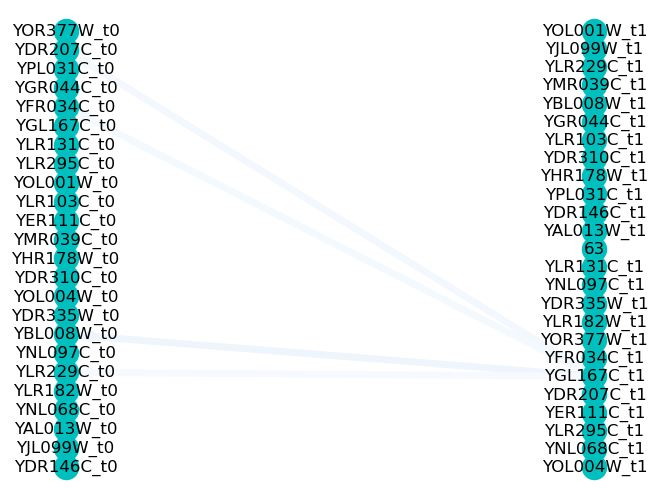

<Figure size 300x200 with 0 Axes>

In [53]:
graph_p = None
graph_p2 = None

graph_p = nx.DiGraph()
graph_p2 = nx.DiGraph()

graph_p.add_nodes_from(range(nnodes*2))
graph_p2.add_nodes_from(range(nnodes*2))

graph_p.add_edges_from(p_edges)
graph_p2.add_edges_from(p_edges)

rnodes = [v + '_t0' for _, v in nodes_names.items()]
rgenes = [v + '_t0' for _, v in nodes_genes.items()]

nodes_names.update({k:v + '_t0' for k, v in nodes_names.items()})
nodes_names.update({k + len(nodes_names):v[:-1] + '1' for k, v in nodes_names.items()})

nodes_genes.update({k:v + '_t0' for k, v in nodes_genes.items()})
nodes_genes.update({k + len(nodes_genes):v[:-1] + '1' for k, v in nodes_genes.items()})

graph_p = nx.relabel_nodes(graph_p, nodes_names, copy=False)
graph_p2 = nx.relabel_nodes(graph_p2, nodes_genes, copy=False)

#pos = nx.shell_layout(graph_y, nlist=[range(nnodes),range(nnodes,nnodes*2)], rotate=0.1, center=(1,5))
pos = nx.bipartite_layout(graph_p, nodes=rnodes)
pos2 = nx.bipartite_layout(graph_p2, nodes=rgenes)

#subax1 = plt.subplot(121)
nx.draw(graph_p, pos, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)

#subax2 = plt.subplot(122)
#nx.draw(graph_p2, pos2, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)
plt.figure(figsize=(3,2))
plt.show()